<center><h1>Bank Marketing Analysis</h1></center>

# Introduction

Marketing campaigns are characterized by focusing on the customer needs and their overall satisfaction. Nevertheless, there are different variables that determine whether a marketing campaign will be successful or not. There are certain variables that we need to take into consideration when making a marketing campaign.

The goal of this notebook is to use the data to develop a strong model in order to predict which people the bank should market to for their marketing campain to get people to sign up for a term deposit.

## What is a Term Deposit?

A **Term deposit** is a deposit that a bank or a financial institurion offers with a fixed rate (often better than just opening deposit account) in which your money will be returned back at a specific maturity time. For more information with regards to Term Deposits please click on this link from Investopedia: https://www.investopedia.com/terms/t/termdeposit.asp

# About the data

Unfortunately, not much about the data is given besides for the below information. More information about where this data came from can be found at this website: 

## Bank client data:<br>
1 - **age:** (numeric)<br>
2 - **job:** type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')<br>
3 - **marital:** marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)<br>
4 - **education:** (categorical: primary, secondary, tertiary and unknown)<br>
5 - **default:** has credit in default? (categorical: 'no','yes','unknown')<br>
6 - **housing:** has housing loan? (categorical: 'no','yes','unknown')<br>
7 - **loan:** has personal loan? (categorical: 'no','yes','unknown')<br>
8 - **balance:** Balance of the individual.

## Related with the last contact of the current campaign:
8 - **contact:** contact communication type (categorical: 'cellular','telephone') <br>
9 - **month:** last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')<br>
10 - **day:** last contact day of the week (categorical: 'mon','tue','wed','thu','fri')<br>
11 - **duration:** last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.<br>
## Other attributes:<br>
12 - **campaign:** number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
13 - **pdays:** number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted)<br>
14 - **previous:** number of contacts performed before this campaign and for this client (numeric)<br>
15 - **poutcome:** outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')<br>

Output variable (desired target):<br>
21 - **deposit** - has the client subscribed a term deposit? (binary: 'yes','no')

# Libraries

## Libraries for plotting and analysis

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib import pyplot
from numpy import where
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Libraries for Modeling

In [50]:
from collections import Counter
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score

## Data Exploration

In [3]:
data = pd.read_csv('bank.csv')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
data.shape

(11162, 17)

In [6]:
df_pivot = pd.DataFrame({'types': data.dtypes,
                         'nulls': data.isna().sum(),
                          '% nulls': data.isna().sum() / data.shape[0],
                          'size': data.shape[0],
                          'uniques': data.nunique()})
df_pivot

,types,nulls,% nulls,size,uniques
age,int64,0,0.0,11162,76
job,object,0,0.0,11162,12
marital,object,0,0.0,11162,3
education,object,0,0.0,11162,4
default,object,0,0.0,11162,2
balance,int64,0,0.0,11162,3805
housing,object,0,0.0,11162,2
loan,object,0,0.0,11162,2
contact,object,0,0.0,11162,3
day,int64,0,0.0,11162,31


In [7]:
int_columns = data.select_dtypes(include=['object'])
int_columns = int_columns.columns.values
int_columns

array(['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'poutcome', 'deposit'], dtype=object)

# Data Cleaning: Numeric Variables

Let's start by cleaning the numeric variables and viewing the basic statistics. 

In [8]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


Before moving on we will remove "duration" from our dataset because of target leakage, or the idea that the field gives information into the future. To put it in another way, this is information that we should not have yet. As noted above this field highly affects the output because if a person had a phone call duration of 0, we can assume the caller didn't pick up the phone and therefore had no chance of a sale.

In [9]:
data.pop("duration")

0        1042
1        1467
2        1389
3         579
4         673
         ... 
11157     257
11158      83
11159     156
11160       9
11161     628
Name: duration, Length: 11162, dtype: int64

Becase "day represents the day of the week we should really treat this as a catigorical variable and not a numeric. Additionally, we will combine these values into 3 buckets: beginning of the month, middle of the month, and end of the month. This will prevent us from having 31 different one-hot encoded variables and generalize the variable so that it makes sense to the business problem at hand. After transforming "day" into a catigorical variable we will one-hot encode it with the other categoriccal variables.

In [10]:
#start = beginning of the month
#middle = middle of the month
#end = end of the month

temp_day = []
for i in data['day']:
    if i<8:
        temp_day.append("start")
    elif i>23:
        temp_day.append("end")
    else:
        temp_day.append("middle")

data['day'] = temp_day

The variable "pdays" represents the number of days that passed by after the client was last contacted from a previous campaign. We need to also note that if the client was never contacted the value of this field is -1. Becuase a value of -1 doesn't make sense in this field and won't properly capture that a client wasn't contacted I would normally create a new binary variable but "poutcome" = nonexistant captures this for us.

Below are some interesting insights we can find from the data:

In [10]:
neg_bal = float(len(data['balance'][data['balance']<0]))/float(len(data['balance']))
print("{:.2%}".format(neg_bal)+ " percent of people or "+str(int(neg_bal*11162))+ " people have a negative balance");

6.16% percent of people or 688 people have a negative balance


In [11]:
first_contact = float(len(data['pdays'][data['pdays']==-1]))/float(len(data['pdays']))
print("Percentage of people that is being contacted for the first time: "+"{:.2%}".format(first_contact));

Percentage of people that is being contacted for the first time: 74.57%


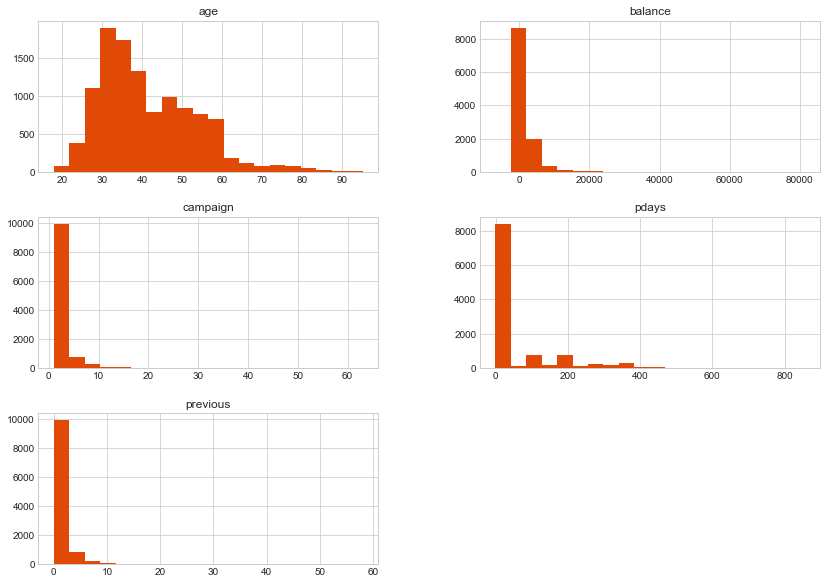

In [12]:
plt.style.use('seaborn-whitegrid')

data.hist(bins=20, figsize=(14,10), color='#E14906')
plt.show()

As we saw from the above statistics of the numeric variables there are potential outliars. Let's talk about some of the max values for some of our variables: <br>

1 - **Balance:** It's not really unheard of to have $81,000 in your checking account. For example, this would make sense from one with a high salary, intersted in saving.<br> 

2 - **pdays:** It's a bit unusual to contact a lead after 854 days (almost 2.5 years) although it is plausable. For instance, maybe after 100 days they were removed from the marketing list but a flag was raised that might indicate that the person is likly will open an account and therefore be put back on the marketing list. Although they were removed then added back, it's possible that they never stopped counting the days in between.<br>

3 - **previous:** Like the previous variables that we discussed this one is also plausable. If a client was in multiple campaigns spanning of many quarters or even years can certainly add up to over 50 contacts.<br>

4 - **Campaign:** Being contated over 60 time for one marketing campaign is a bit unheard of even for a campaign that lasts a year. Think about it, after reaching out to a person 20 don't you think they probably aren't interested? Also, most companies won't waste money like that. This will need more investigating. <br>


# Outliar Analysis

In [13]:
data.nlargest(20,"campaign")

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
7635,45,management,married,unknown,no,9051,yes,no,unknown,middle,may,63,-1,0,unknown,no
6927,51,blue-collar,married,unknown,no,41,yes,no,telephone,middle,jul,43,-1,0,unknown,no
7240,33,blue-collar,married,secondary,no,0,yes,yes,cellular,end,jul,43,-1,0,unknown,no
7139,42,blue-collar,married,primary,no,170,yes,no,unknown,middle,may,41,-1,0,unknown,no
9683,49,services,divorced,secondary,no,933,no,yes,cellular,end,jul,33,-1,0,unknown,no
4912,50,entrepreneur,married,primary,no,461,yes,no,unknown,middle,may,32,-1,0,unknown,yes
7237,42,self-employed,married,tertiary,no,1932,yes,no,unknown,middle,may,32,-1,0,unknown,no
10293,31,services,married,unknown,no,-82,yes,no,cellular,end,jul,31,-1,0,unknown,no
7763,44,services,divorced,secondary,no,608,yes,yes,unknown,middle,jun,30,-1,0,unknown,no
10865,51,services,married,secondary,no,7,yes,no,cellular,end,jul,30,-1,0,unknown,no


Based on the above data there is no indication of an error in the above data. It looks like all of the above data all have that they were previously not contacted before. I could be that possibly that the company wanted to take an aggesive approach to marketing to fresh leads. Because of this reasoning I will not take out any observations although I will make sure to keep this in mind. Although, I decided not to throw out any variables, there is certainly a strong case to be made for tossing rows or transforming the columns to adjust for the outliers.

# Data Cleaning: Catigorical Variables

In [11]:
#populate a list with string-type columns
str_columns = []
for i in data.columns:
    if(type(data[i][0])==str):
        str_columns.append(i)

In [18]:
str_columns_2 = data.select_dtypes(include=['object'])
str_columns_2 = str_columns_2.columns
str_columns_2

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'day', 'month', 'poutcome', 'deposit'],
      dtype='object')

In [15]:
print(str_columns)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'poutcome', 'deposit']


## Adjusting the Binary Categorical Variables

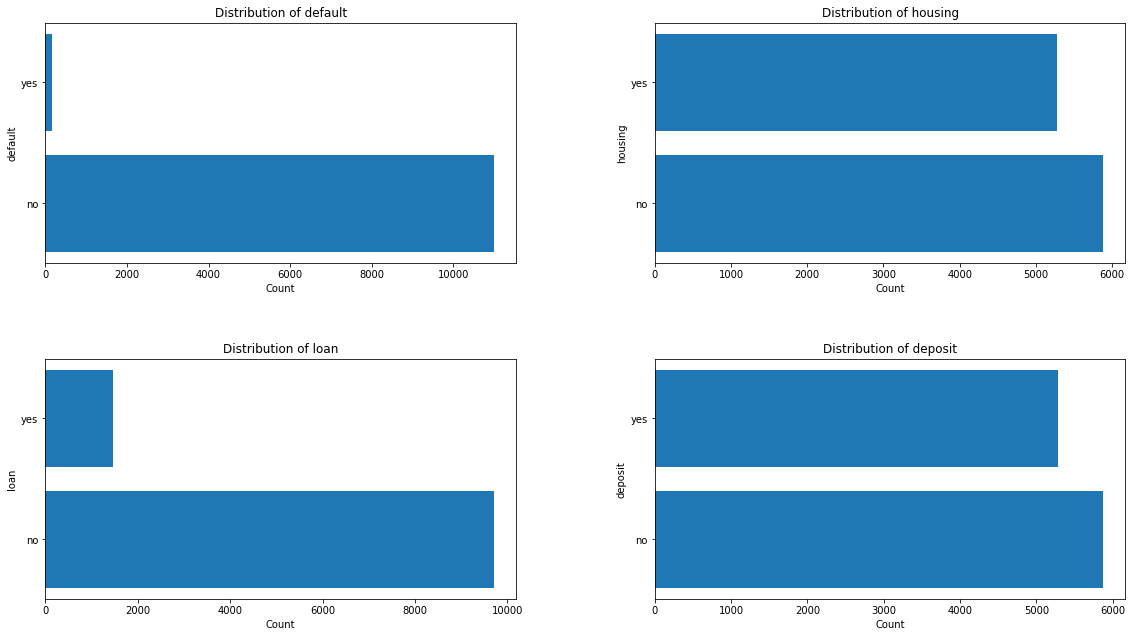

In [30]:
fig, axes = plt.subplots(2,2)
fig.tight_layout(h_pad=2)

bin_list = [3,4,5,10]

for i in range(1,5):
    plt.subplot(2, 2, i)
    n = bin_list[i-1]
    counts = data[str_columns[n]].value_counts()
    plt.barh(y=counts.index, width=counts)
    plt.title('Distribution of '+str_columns[n])
    plt.ylabel(str_columns[n])
    plt.xlabel('Count')

plt.subplots_adjust(left=.25, bottom=2, right=2.75, top=4)

In [31]:
# change the character values in the above columns to 0/1 binary values
# 0="no" and 1="yes"

data['default'] = [0 if i == "no" else 1 for i in data['default']]
data['housing'] = [0 if i == "no" else 1 for i in data['housing']]
data['loan']    = [0 if i == "no" else 1 for i in data['loan']   ]
data['deposit'] = [0 if i == "no" else 1 for i in data['deposit']]

In [ ]:
#alternative code:

# new_df['Partner'].replace({'Yes' : 1, 'No' : 0},inplace = True)
# new_df['Dependents'].replace({'Yes' : 1, 'No' : 0},inplace = True)
# new_df['PhoneService'].replace({'Yes' : 1, 'No' : 0},inplace = True)
# new_df['MultipleLines'].replace({'Yes' : 1, 'No' : 0},inplace = True)

In [32]:
#check
print(data['default'].value_counts())
print(data['housing'].value_counts())
print(data['loan'].value_counts())
print(data['deposit'].value_counts())

0    10994
1      168
Name: default, dtype: int64
0    5881
1    5281
Name: housing, dtype: int64
0    9702
1    1460
Name: loan, dtype: int64
0    5873
1    5289
Name: deposit, dtype: int64


In [33]:
#adjust our string list and remove the four variables above
for i in ['default','housing','loan','deposit']:
    str_columns.remove(i)
    
print(str_columns)

['job', 'marital', 'education', 'contact', 'day', 'month', 'poutcome']


In [34]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,0,2343,1,0,unknown,start,may,1,-1,0,unknown,1
1,56,admin.,married,secondary,0,45,0,0,unknown,start,may,1,-1,0,unknown,1
2,41,technician,married,secondary,0,1270,1,0,unknown,start,may,1,-1,0,unknown,1
3,55,services,married,secondary,0,2476,1,0,unknown,start,may,1,-1,0,unknown,1
4,54,admin.,married,tertiary,0,184,0,0,unknown,start,may,2,-1,0,unknown,1


## Adjusting the other categorical variables

In [21]:
print(str_columns)

['job', 'marital', 'education', 'contact', 'day', 'month', 'poutcome']


Above we adjusted the binary categorical variables and turned them into numeric variables that we can work with. Now we can transform the categorical variables that contain more than one unique value using one-hot encoding. Before we transform the variables we must view the distribtion to get an idea of the behavior for each variable.

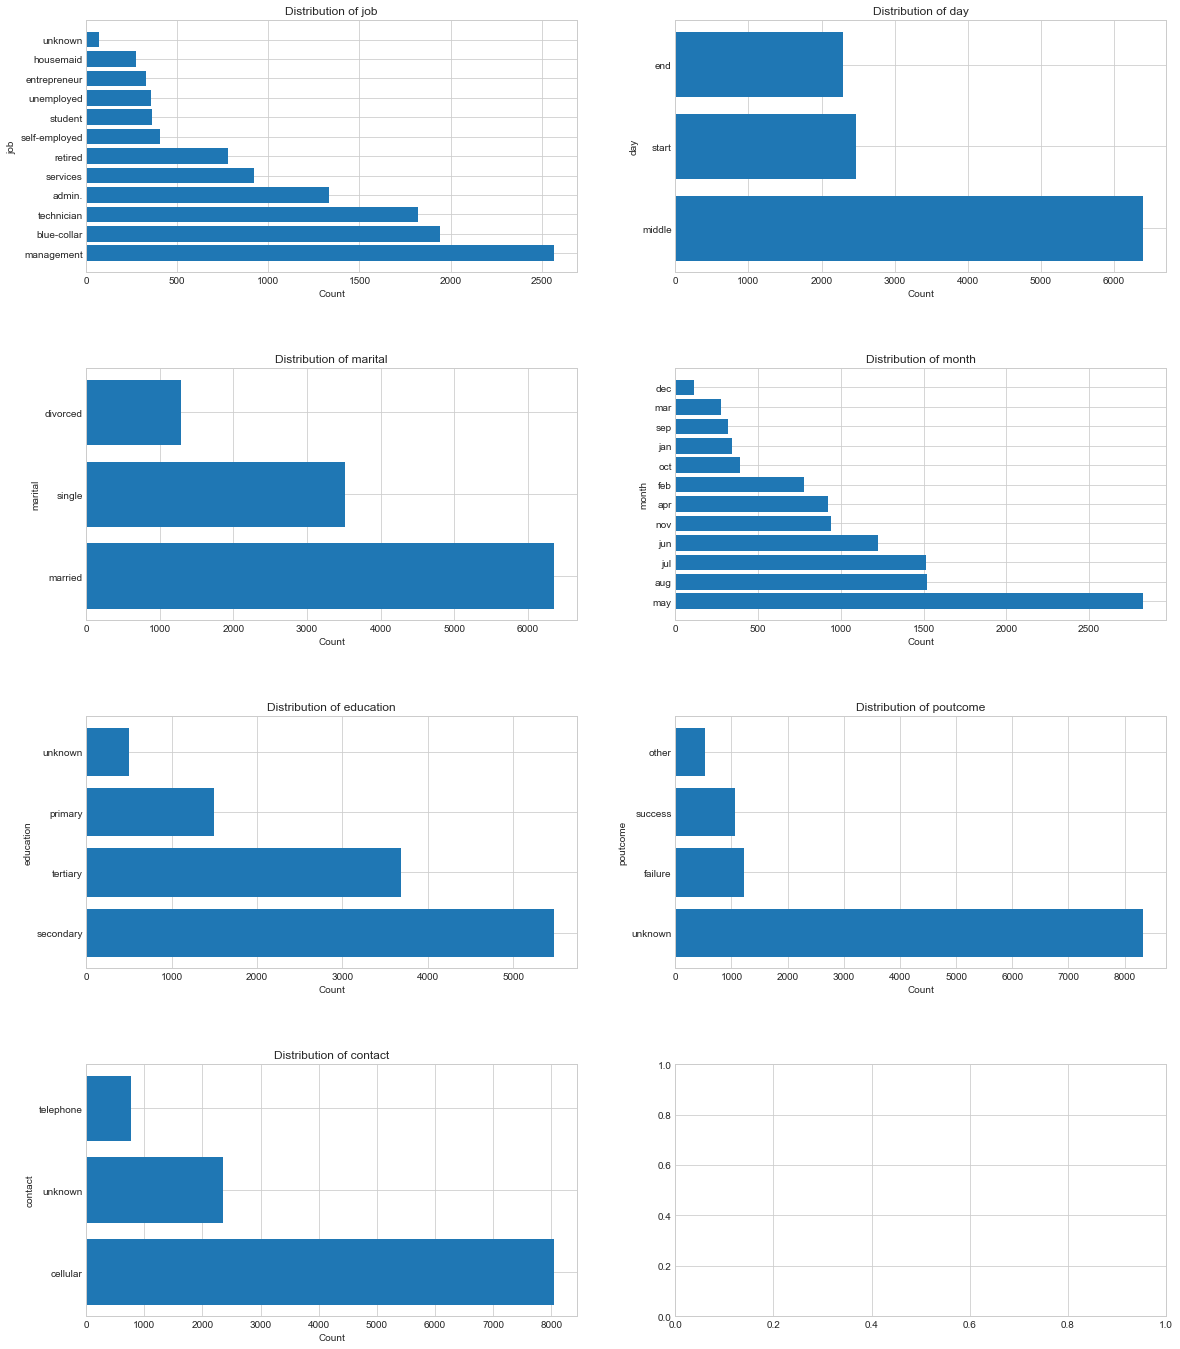

In [22]:
fig, axes = plt.subplots(4,2)
fig.tight_layout(h_pad=.25)

j = 0
k = 0 
for i in range(1,8):
    if k==4:
        k=0
        j=1
    plt.subplot2grid((4, 2), (k,j))
    n = i-1
    counts = data[str_columns[n]].value_counts()
    plt.barh(y=counts.index, width=counts)
    plt.title('Distribution of '+str_columns[n])
    plt.ylabel(str_columns[n])
    plt.xlabel('Count')
    k=k+1
                     
plt.subplots_adjust(left=.25, bottom=.5, right=2.75, top=5)

A few notes from the above distributions:

+ It's interesting that the largest volume of calls happen in the summer months and weakest in the colder months.
+ Remember that "poutcome" reflects how they responded to a previous campaign. We should note that about 75% in this category is labeled as "unknown" which is consistant with what we found earlier.
+ based on the demographic variables, it seems like this campaign targets middle class individuals which supports the statistics from our "balance" variable.  

This information will be valuable when we review the results of our final model

In [35]:
# let's use one-hot encodin to change the categorical variables to numericals
data = pd.get_dummies(data)
print(len(data.columns))
print(data.columns)

50
Index(['age', 'default', 'balance', 'housing', 'loan', 'campaign', 'pdays',
       'previous', 'deposit', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'education_unknown', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'day_end', 'day_middle',
       'day_start', 'month_apr', 'month_aug', 'month_dec', 'month_feb',
       'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown'],
      dtype='object')


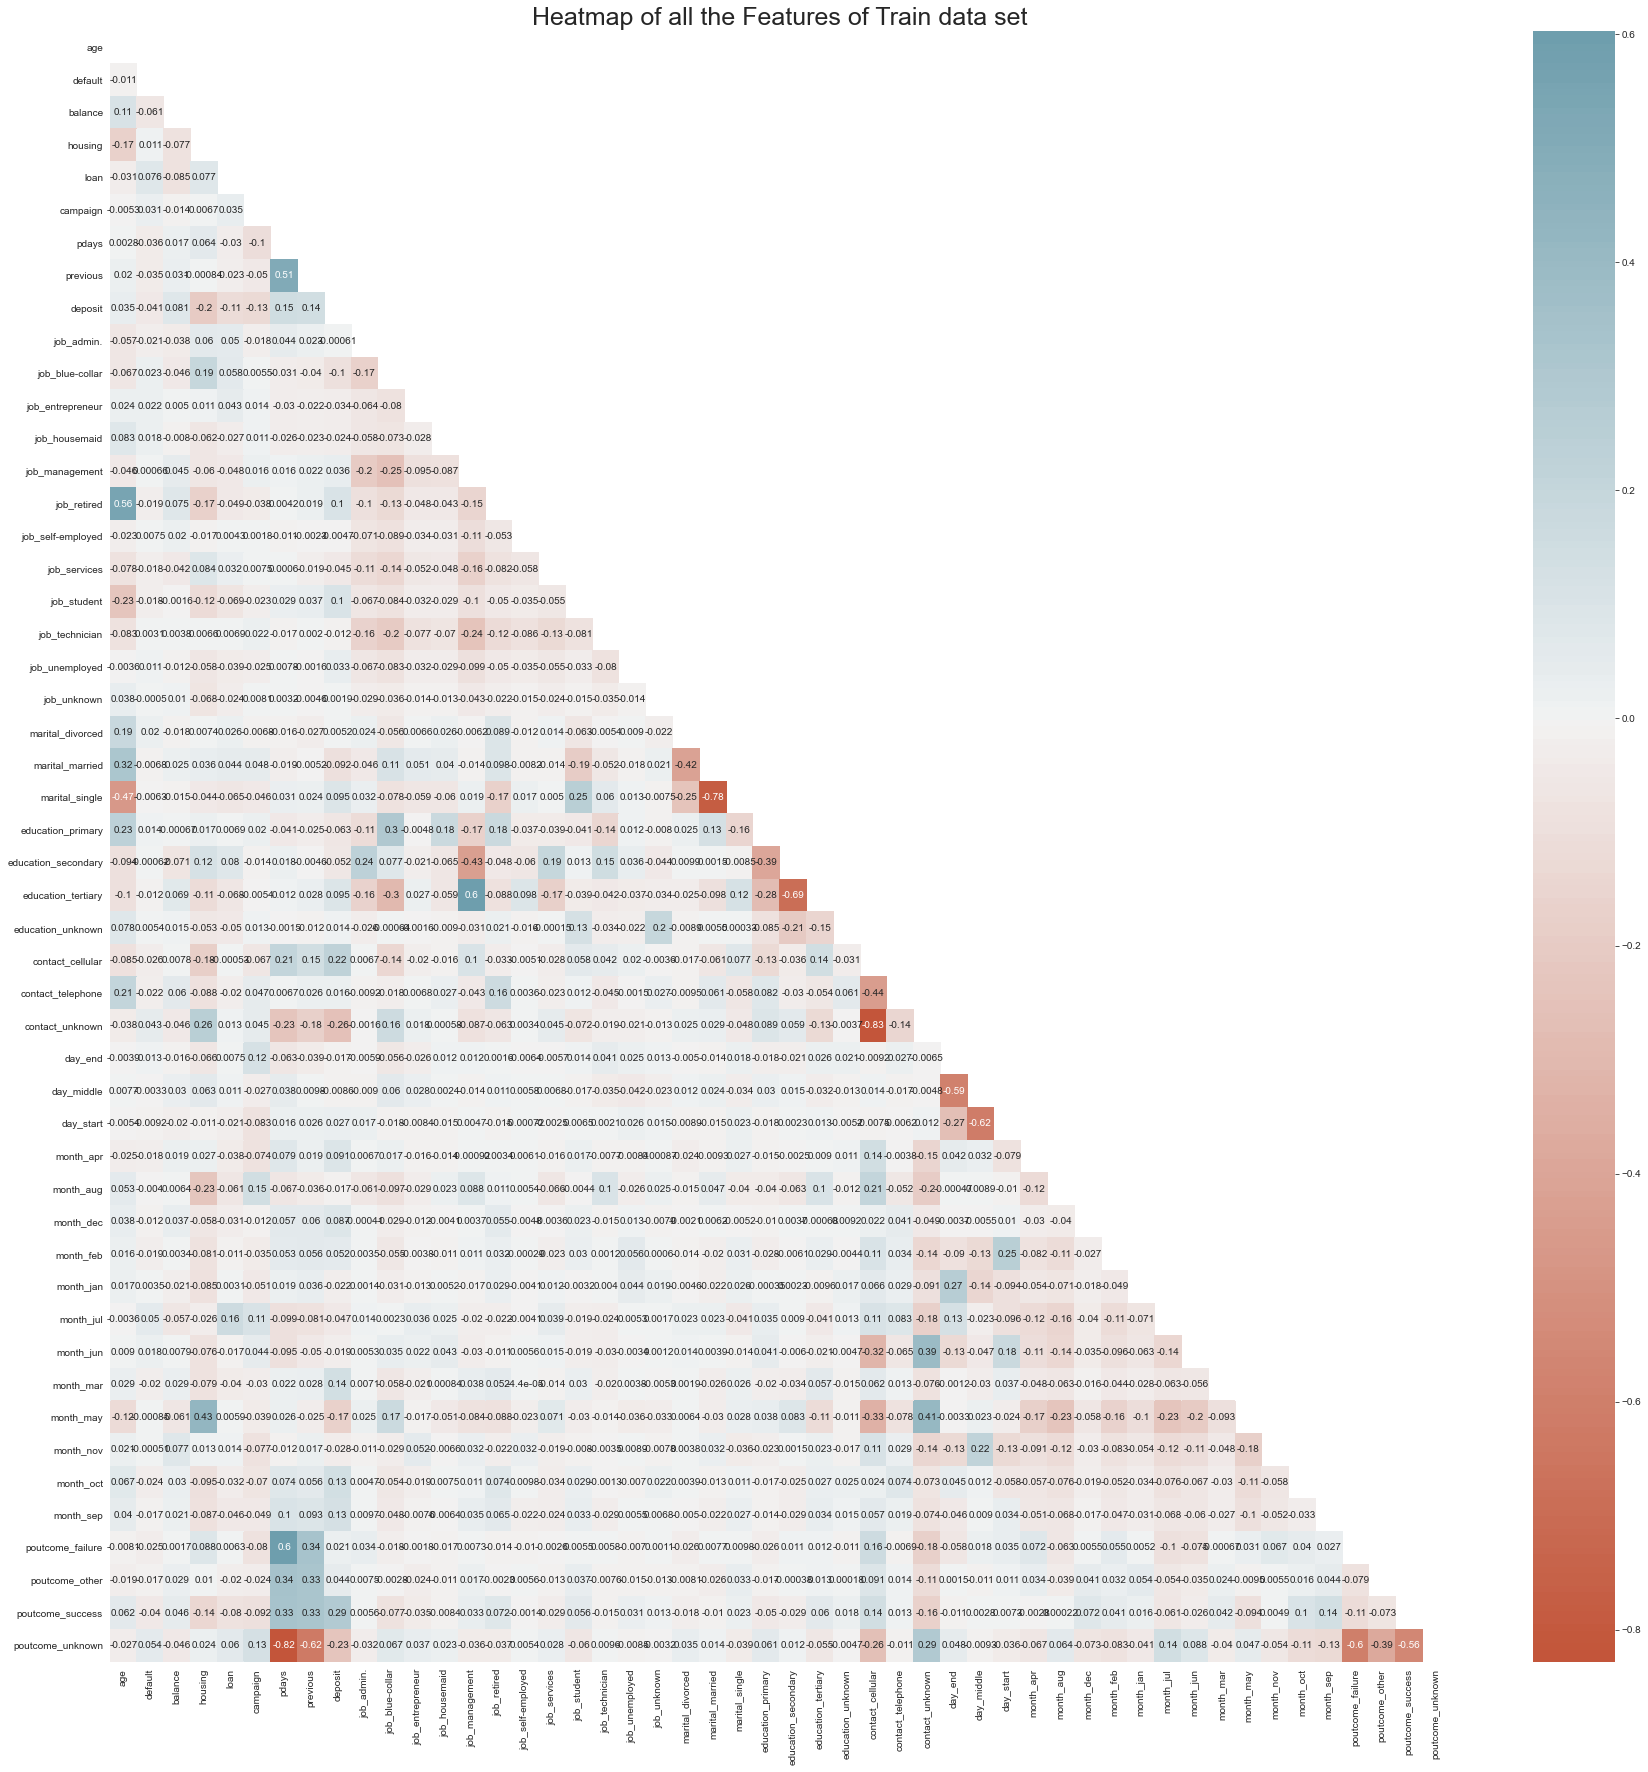

In [36]:
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (30,30))
## Plotting heatmap. Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data.corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0, );
plt.title("Heatmap of all the Features of Train data set", fontsize = 25);

Based on the above correlation table the categorical variables that got encoded with exactly 3 unique values appear to have multicolinnearity. This can probably be attributed to the fact that 2 of the encoded values will together have information on the third. For example, if there are three choices between pcoucome (success, failure, unknown) and it wasn't a success or a failure, the data will assume it was unknown. Therefore we can remove one of these encoded variables from each of the categorical varible with three unique values.

In [37]:
#delete: poutcome_unknown, marital_single, day_end, contact_unknown

data.pop("poutcome_unknown")
data.pop("marital_single")
data.pop("day_end")
data.pop("contact_unknown")

0        1
1        1
2        1
3        1
4        1
        ..
11157    0
11158    1
11159    0
11160    0
11161    0
Name: contact_unknown, Length: 11162, dtype: uint8

# Modeling

Below are a few functions to streamline our modeling

In [81]:
accuracies = {}
kappaScores= {}
f1scores={}

def Models(models, X_train, X_test, y_train, y_test, title):
    model = models
    model.fit(X_train,y_train)
    
    X, y = Definedata()
    train_matrix = pd.crosstab(y_train, model.predict(X_train), rownames=['Actual'], colnames=['Predicted'])    
    test_matrix = pd.crosstab(y_test, model.predict(X_test), rownames=['Actual'], colnames=['Predicted'])
    matrix = pd.crosstab(y, model.predict(X), rownames=['Actual'], colnames=['Predicted'])
    
    f,(ax1,ax2,ax3) = plt.subplots(1,3,sharey=True, figsize=(20, 3))
    #f = plt.figure(figsize=(20, 3))
    
    g1 = sns.heatmap(train_matrix, annot=True, fmt=".1f", cbar=False,ax=ax1)
    g1.set_title(title)
    g1.set_ylabel('Total Deposit = {}'.format(y_train.sum()), fontsize=14, rotation=90)
    g1.set_xlabel('Accuracy score for Training Dataset = {}'.format(accuracy_score(model.predict(X_train), y_train)))
    g2 = sns.heatmap(test_matrix, annot=True, fmt=".1f",cbar=False,ax=ax2)
    g2.set_title(title)
    g2.set_ylabel('Total Deposit = {}'.format(y_test.sum()), fontsize=14, rotation=90)
    g2.set_xlabel('Accuracy score for Testing Dataset = {}'.format(accuracy_score(model.predict(X_test), y_test)))
    g3 = sns.heatmap(matrix, annot=True, fmt=".1f",cbar=False,ax=ax3)
    g3.set_title(title)
    g3.set_ylabel('Total Deposit = {}'.format(y.sum()), fontsize=14, rotation=90)
    g3.set_xlabel('Accuracy score for Total Dataset = {}'.format(accuracy_score(model.predict(X), y)))
    
    #record metrics
    accuracies[title]=accuracy_score(model.predict(X_test), y_test)*100
    f1scores[title]=f1_score(model.predict(X_test), y_test)*100
    kappaScores[title]=cohen_kappa_score(model.predict(X_test), y_test)*100
    
    plt.show()
    return y, model.predict(X)

In [45]:
import plotly.graph_objects as go

def Featureimportances(models, X_train, y_train):
    model = RandomForestClassifier()
    model.fit(X_train,y_train)
    importances = model.feature_importances_
    features = data.columns
    if len(importances)<len(features): 
        features = data.columns[:len(importances)]
    else:
        importances = model.feature_importances_[:len(features)]
    imp = pd.DataFrame({'Features': features, 'Importance': importances})
    imp = imp.sort_values(by = 'Importance', ascending=False)[:15]
    imp['Sum Importance'] = imp['Importance'].cumsum()
    
    fig = go.Figure()
    fig.add_trace(go.Bar(x=imp.Features,y=imp.Importance, marker=dict(color=list(range(20)), colorscale="Sunsetdark")))

    fig.update_layout(title="Feature Importance",
                                 xaxis_title="Features", yaxis_title="Importance",title_x=0.5, paper_bgcolor="mintcream",
                                 title_font_size=20)
    fig.show()

In [46]:
def Definedata():
    # define dataset
    X=data.drop(columns=['deposit']).values
    y=data['deposit'].values
    return X, y

In [61]:
# define dataset
data.dropna(inplace=True)
X=data.drop(columns=['deposit']).values
y=data['deposit'].values

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2)

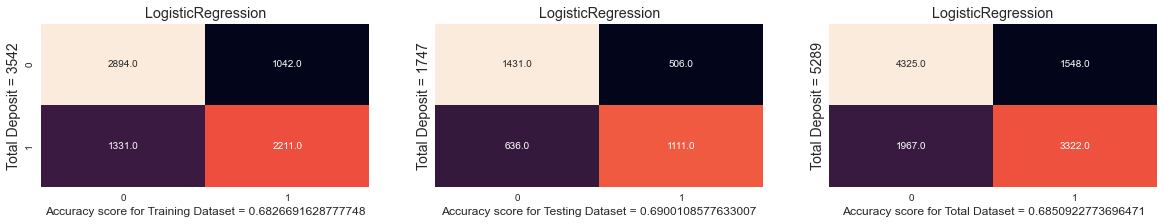

Wall time: 814 ms


(array([1, 1, 1, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 1, 0, 1], dtype=int64))

In [82]:
title = 'LogisticRegression'
%time Models(LogisticRegression(),X_train, X_test, y_train, y_test, title) 

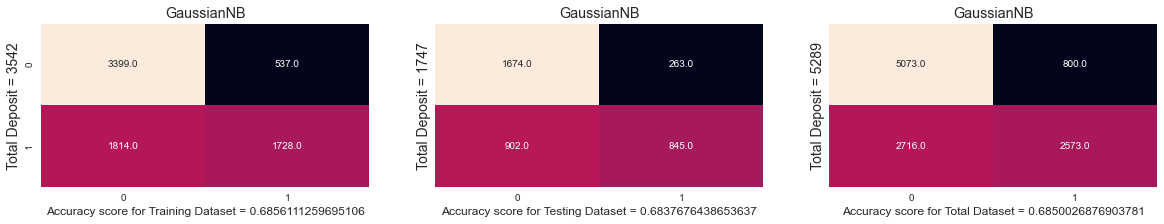

Wall time: 597 ms


(array([1, 1, 1, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

In [83]:
title = 'GaussianNB'
%time Models(GaussianNB(),X_train, X_test, y_train, y_test, title)

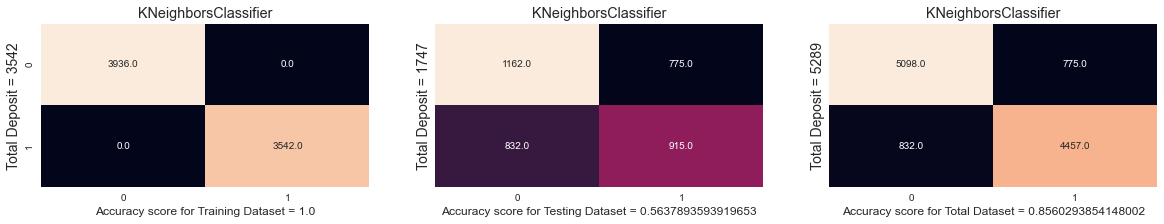

Wall time: 12.9 s


(array([1, 1, 1, ..., 0, 0, 0], dtype=int64),
 array([1, 1, 1, ..., 0, 0, 0], dtype=int64))

In [84]:
title = 'KNeighborsClassifier'
%time Models(KNeighborsClassifier(n_neighbors=1),X_train, X_test, y_train, y_test, title)

In [ ]:
# code for finding the optimal number of k neigbors 

# Error = []

# for i in range(1, 51):
#     knn = KNeighborsClassifier(n_neighbors=i)
#     knn.fit(X_train, y_train)
#     y_pred = knn.predict(X_test)
#     Error.append(mean_squared_error(y_test,y_pred))
    
    
    
# plt.figure(figsize=(10,5))
# plt.plot(range(1,51), Error, color = 'blue', marker = 'o', markerfacecolor = 'red', markersize = 10)

# plt.title('Error rate vs K. value')
# plt.xlabel('k')
# plt.ylabel('Error Rate')

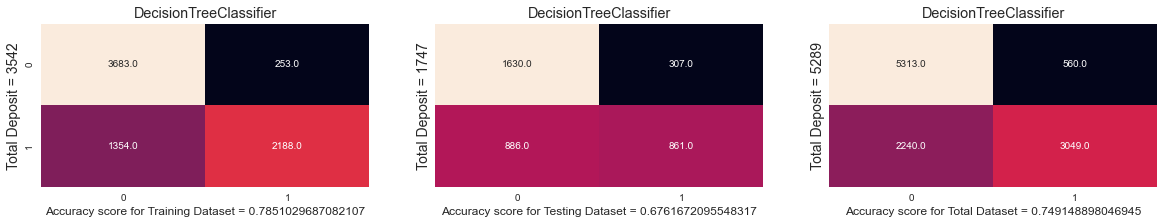

Wall time: 580 ms


(array([1, 1, 1, ..., 0, 0, 0], dtype=int64),
 array([0, 1, 0, ..., 0, 0, 0], dtype=int64))

In [85]:
title = 'DecisionTreeClassifier'
%time Models(DecisionTreeClassifier(max_depth=14),X_train, X_test, y_train, y_test, title)

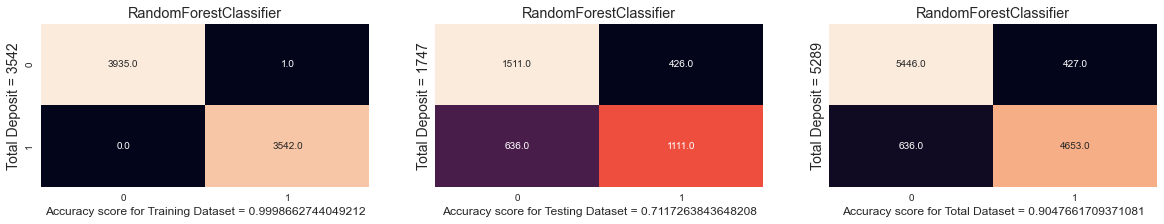

Wall time: 3.46 s


(array([1, 1, 1, ..., 0, 0, 0], dtype=int64),
 array([1, 1, 1, ..., 0, 0, 0], dtype=int64))

In [86]:
title = 'RandomForestClassifier'
%time Models(RandomForestClassifier(),X_train, X_test, y_train, y_test, title)

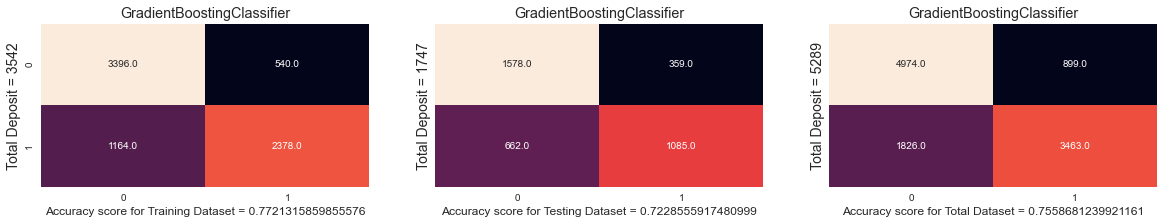

Wall time: 2.02 s


(array([1, 1, 1, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

In [87]:
title = 'GradientBoostingClassifier'
%time Models(GradientBoostingClassifier(n_estimators=500, learning_rate=1, max_features=2, max_depth=2, random_state=0),X_train, X_test, y_train, y_test, title)

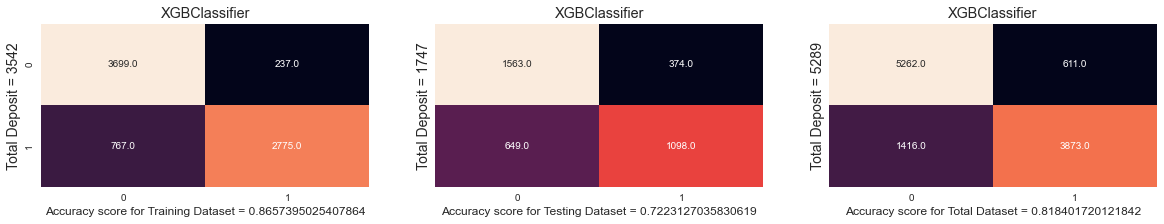

Wall time: 2.59 s


(array([1, 1, 1, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

In [88]:
title = 'XGBClassifier'
%time Models(XGBClassifier(),X_train, X_test, y_train, y_test, title)

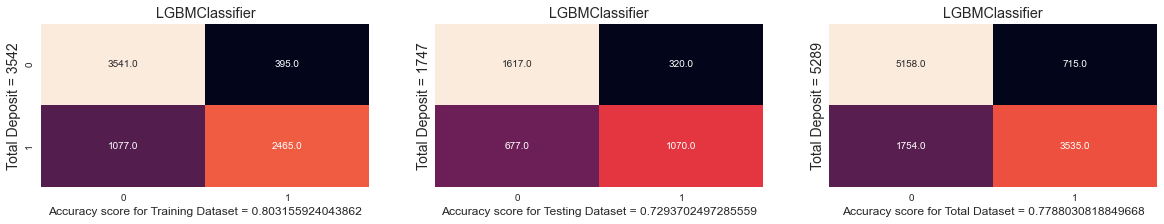

Wall time: 1.29 s


(array([1, 1, 1, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

In [89]:
title = 'LGBMClassifier'
%time Models(LGBMClassifier(),X_train, X_test, y_train, y_test, title)

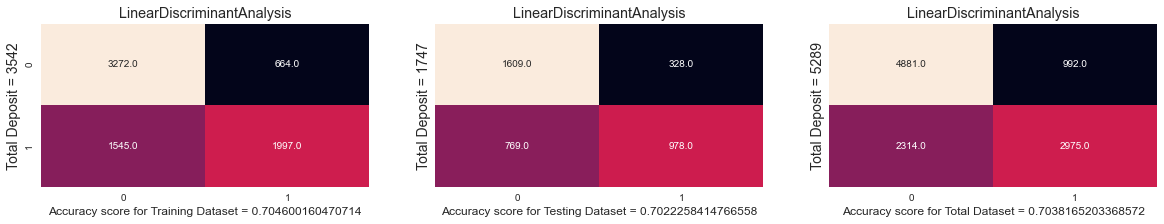

Wall time: 579 ms


(array([1, 1, 1, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

In [91]:
data.dropna(inplace=True)
title = 'LinearDiscriminantAnalysis'
%time Models(LinearDiscriminantAnalysis(),X_train, X_test, y_train, y_test, title)

# Compare the Models

## Comparison of Kappa Scores

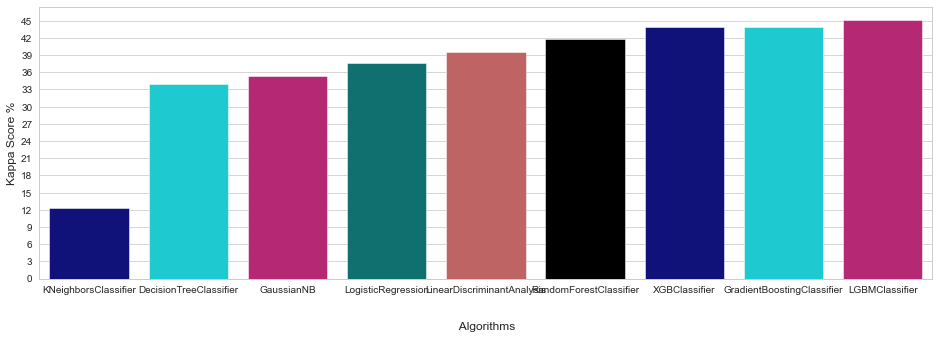

In [98]:
colors = ["#00008b", "#00e5ee", "#cd1076", "#008080","#cd5555",'black']

keys = sorted(kappaScores, key=kappaScores.__getitem__)
values = sorted(kappaScores.values())

sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,3))
plt.ylabel("Kappa Score %")
plt.xlabel("\n\n Algorithms")
sns.barplot(x=list(keys), y=list(values), palette=colors)
plt.show()

## Comparison of the F1 Statistic

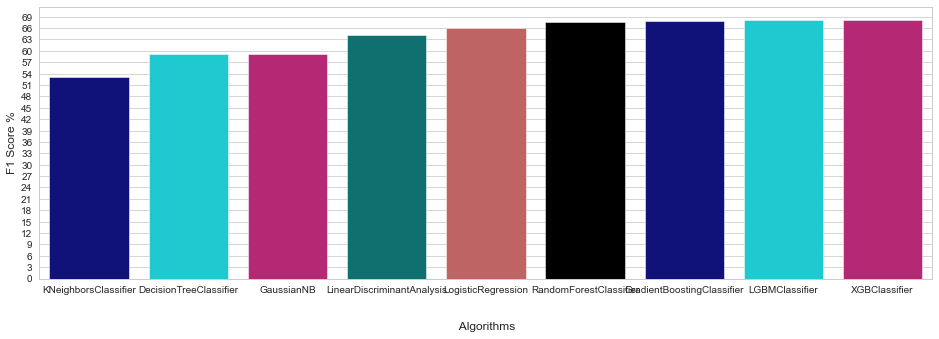

In [99]:
colors = ["#00008b", "#00e5ee", "#cd1076", "#008080","#cd5555",'black']

keys = sorted(f1scores, key=f1scores.__getitem__)
values = sorted(f1scores.values())

sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,3))
plt.ylabel("F1 Score %")
plt.xlabel("\n\n Algorithms")
sns.barplot(x=list(keys), y=list(values), palette=colors)
plt.show()

## Comparison of the Accuracy

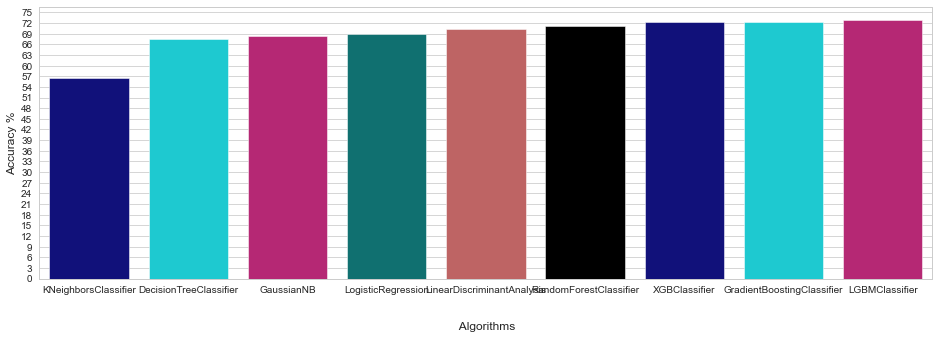

In [100]:
colors = ["#00008b", "#00e5ee", "#cd1076", "#008080","#cd5555",'black']

keys = sorted(accuracies, key=accuracies.__getitem__)
values = sorted(accuracies.values())

sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,3))
plt.ylabel("Accuracy %")
plt.xlabel("\n\n Algorithms")
sns.barplot(x=list(keys), y=list(values), palette=colors)
plt.show()

# Analyze the Strongest Model

Let's take a closer look at the Random Forrest Model since that was one of our most predictive models

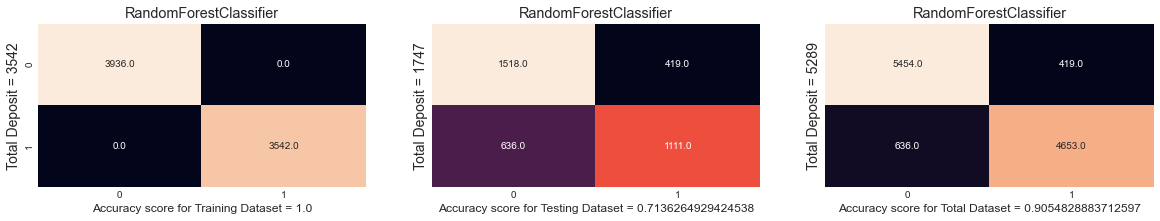

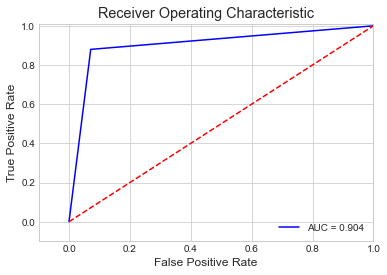

In [74]:
from sklearn.metrics import confusion_matrix,auc,roc_curve

title = 'RandomForestClassifier'
y, ypred =  Models(RandomForestClassifier(),X_train, X_test, y_train, y_test, title)

fpr, tpr, thresholds = roc_curve(y, ypred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Above we have our 3 confustion matricies that were seen before along with an ROC curve.To briefly analyze the confusion matricies, we have a strong Accuracy for our test set with a value of about 0.71 and a strong Accuacy for our full dataset with an Accuracy of about 0.91. 

Below the confustion matricies, we can see the ROC curve with a value of 0.904 which is very strong. The ROC curve shows the trade-off between sensitivity (or TPR) and specificity (1 – FPR). Classifiers that give curves closer to the top-left corner indicate a better performance. As a baseline, a random classifier is expected to give points lying along the diagonal (FPR = TPR). The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test. In other words, the 45-degree line represents randomly choosing an outcome.

In [71]:
Featureimportances(RandomForestClassifier(), X_train, y_train)

Right off the bat we can point out that our two most important features in our model are balance and age. Athough this chart doesn't tell us the direction of the feature (if it's positively or negativly affecting the outcome taking everything else constant) we can imply a few things. First, the larger the balance the more money is saved in the bank. The more money that's saved in the bank the more likely you'll have extra money to put towards a term deposti. Second, the older a person is, the more time they have had accumulating wealth. Therefore, they are more likely to have extra money to put toward a term deposit. It might be important to point out that the next three features are attributed to the campaign. 

It's also important to note that although there are two powerful features, there is a healthy amount of importance distributed among the top 10 features in our model. 

# Conclusion & Future Work

In total of 9 algorithms were used to classify whether a person would open a term deposit with the bank. Three metrics were used in evaluating their performances. Performance improvement could be achieved through developing an ensambled model, a combination of different algorithms. Although we focused on the Random Forest Model, it could be observed that the 3 following algorithms outperformed other models in terms of the Accuracy.

1. RandomForestClassifier 
2. GradientBoostingClassifier
3. XGBClassifier

It is worth noting that, understanding the business problem, how the dataset is built, and deeply understanding the variables at hand is essential for building an acccurate and significant model. 

Future work will include a comprehensive tuning of these 4 algorithms. 

# References

[1] https://www.kaggle.com/janiobachmann/bank-marketing-campaign-opening-a-term-deposit 

[2] https://www.kaggle.com/winternguyen/credit-card-100-fraud-detection

[3] https://archive.ics.uci.edu/ml/datasets/Bank+Marketing
